# Оценка качества вин

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd
import scipy.stats as sts
import statsmodels.stats.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")

%matplotlib inline

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. **Modeling wine preferences by data mining from physicochemical properties.** *Decision Support Systems*, 47(4):547-553, 2009: имеются оценки качества 6497 португальских вин Vinho Verde, выставленные дегустаторами при слепом тестировании в баллах по шкале от 0 до 10. 

Прочитаем данные:

In [4]:
wine = pd.read_csv('data/09_wine_data.csv', sep='\t', header=0)
wine = wine.sample(frac=1)

Вот так выглядит распределение экспертных оценок вин в выборке:

Text(0.5,0,'Quality')

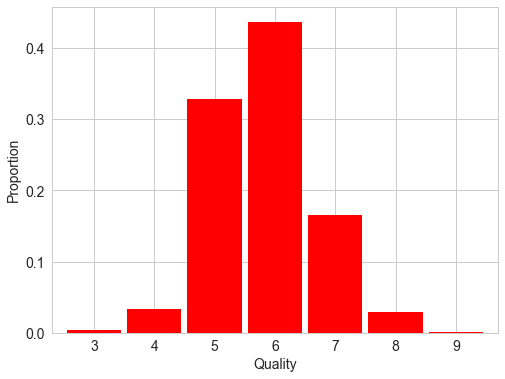

In [7]:
plt.figure(figsize=(8,6))
stat = wine.groupby('quality')['quality'].agg(lambda x : float(len(x))/wine.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Давайте научимся оценивать этот признак, чтобы мы могли заранее предположить, какую оценку получит какое-то новое вино, которого в выборке нет. 
Чтобы смоделировать такую ситуацию, отделим 25% выборки для контроля качества предсказания:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(wine.iloc[:, wine.columns != 'quality'], wine['quality'], test_size=0.25, 
                                                    stratify=wine[['Type', 'quality']])

In [18]:
X_train['Type'] = X_train['Type'].apply(lambda x : -1 if x == 'red' else 1)
X_test['Type'] = X_test['Type'].apply(lambda x : -1 if x == 'red' else 1)

Если у нас нет больше никакой информации о винах, то наше лучшее предположение об оценке — среднее имеющихся в обучающей выборке:

In [19]:
np.mean(y_train)

5.817733990147783

Если мы будем предсказывать этой величиной оценку всех вин, на обучающей выборке мы получим среднеквадратичную ошибку

In [22]:
from math import sqrt

sqrt(mean_squared_error([np.mean(y_train)]*len(y_train), y_train))

0.8735940831862377

а на тестовой

In [23]:
sqrt(mean_squared_error([np.mean(y_train)]*len(y_test), y_test))

0.8719705746838052

На тестовой выборке ошибка больше, поскольку среднее мы оценивали по обучающей. Это естественный эффект.

# Тип вина

Какая-то ещё информация у нас есть, например, о типе вина:

In [25]:
wine.groupby('Type')['Type'].count()

Type
red      1599
white    4898
Name: Type, dtype: int64

Распределения оценок по типам довольно сильно отличаются:

Text(0.5,0,'Quality')

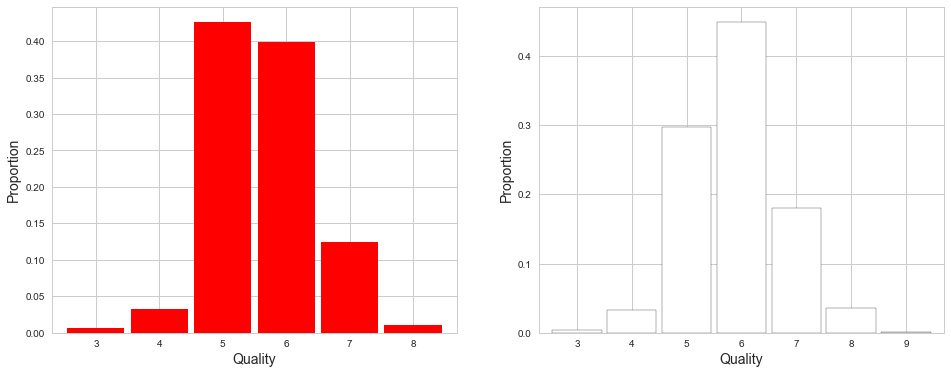

In [70]:
plt.figure(figsize=(16,6))

plt.subplot(121)
stat_red = wine[wine['Type'] == 'red'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'red'].shape[0])
stat_red.plot(kind='bar', color='r', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

plt.subplot(122)
stat_white = wine[wine['Type'] == 'white'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'white'].shape[0])
stat_white.plot.bar(color='w', width=0.9, edgecolor='k')
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Различие между средними статистически значимо:

In [72]:
tmeans = sm.CompareMeans(sm.DescrStatsW(wine[wine['Type'] == 'white']['quality']), 
                         sm.DescrStatsW(wine[wine['Type'] == 'red']['quality']))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

4.888069044201508e-22

95% доверительный интервал для разности средних оценок:

In [73]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.19293009404017963, 0.290843579328052)

Чтобы уточнить наше предсказание, можно оценку каждого вина предсказывать средним по оценкам вин такого же типа в выборке:

In [76]:
regressor = LinearRegression()
regressor.fit(X_train['Type'].values.reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
y_train_predictions = regressor.predict(X_train['Type'].values.reshape(-1,1))

In [79]:
y_test_predictions = regressor.predict(X_test['Type'].values.reshape(-1,1))

Ошибки предсказания немного уменьшились:

In [80]:
sqrt(mean_squared_error(y_train_predictions, y_train))

0.8671965001753594

In [81]:
sqrt(mean_squared_error(y_test_predictions, y_test))

0.8662137838266157

Вот так выглядят истинные оценки вин и их предсказания средними по типам на тестовой выборке:

Text(0,0.5,'Estimated quality')

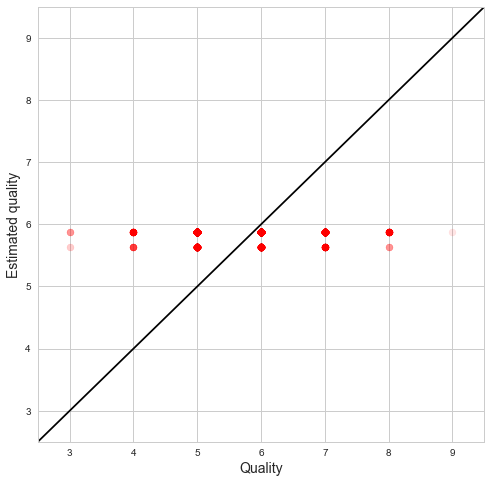

In [86]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_test_predictions, color="red", alpha=0.1)
plt.xlim(2.5,9.5)
plt.ylim(2.5,9.5)
plt.plot(range(11), color='black')
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

# Другие признаки

На самом деле у нас есть ещё 11 признаков, описывающих химический состав вин:

In [87]:
wine.head()

,Type,Fixed acidity (g/l),Volatile acidity (g/l),Citric acid (g/l),Residual sugar (g/l),Chlorides (g/l),Free sulfur dioxide (mg/l),Total sulfur dioxide (mg/l),Density (g/cm3),pH,Sulphates (g/l),Alcohol (%),quality
5193,white,6.8,0.19,0.32,7.6,0.049,37.0,107.0,0.99332,3.12,0.44,10.7,7
5789,white,7.0,0.22,0.30,1.4,0.040,14.0,63.0,0.98985,3.20,0.33,12.0,6
2305,white,6.2,0.31,0.21,6.3,0.041,50.0,218.0,0.99410,3.15,0.60,10.0,5
4938,white,7.6,0.17,0.27,4.6,0.050,23.0,98.0,0.99422,3.08,0.47,9.5,6
2638,white,7.5,0.17,0.34,1.4,0.035,13.0,102.0,0.99180,3.05,0.74,11.0,5


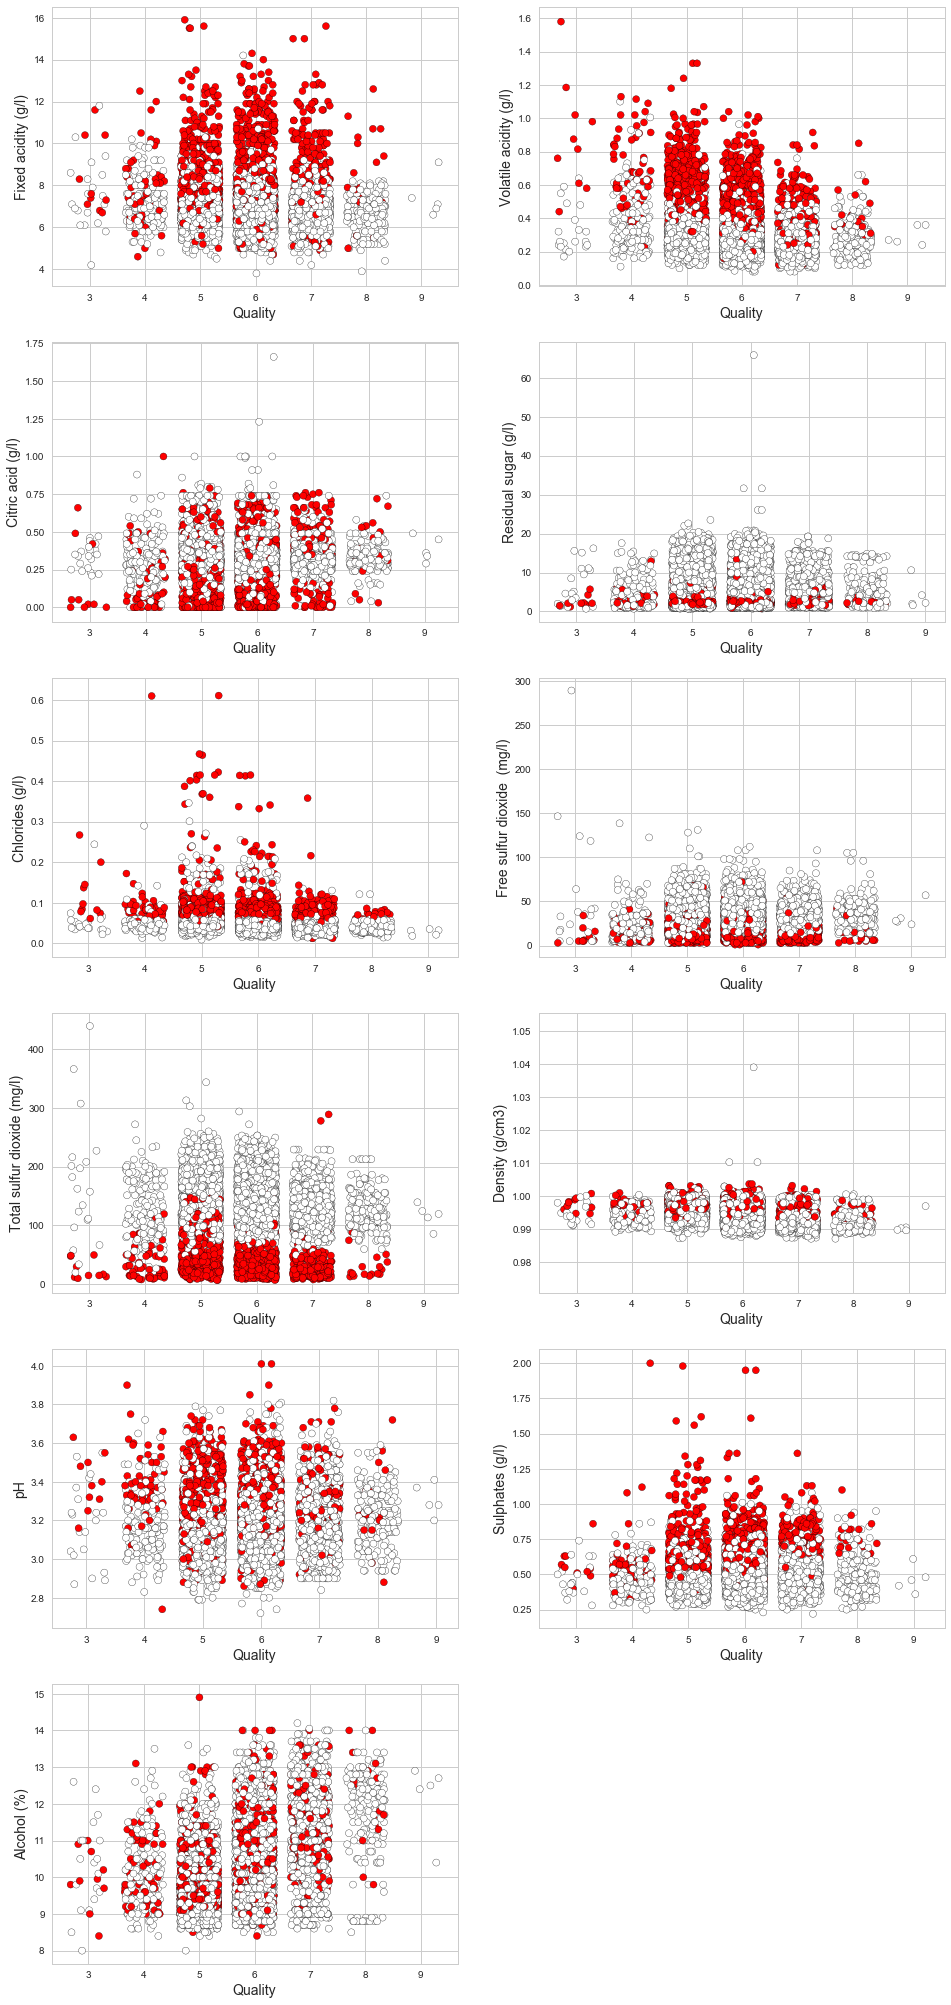

In [90]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

plt.figure(figsize=(16, 36))
for i in range (1, 12):
    plt.subplot(6, 2, i)
    plt.scatter(jitter(wine['quality']), wine.iloc[:, i], color=wine["Type"], edgecolors="black")
    plt.xlabel('Quality', fontsize=14)
    plt.ylabel(str(wine.columns[i]), fontsize=14)

Попробуем их учесть при построении прогноза оценок.

## Линейная регрессия

Построим для начала линейную регрессионную модель.

In [91]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Ошибки предсказания существенно уменьшились:

In [92]:
sqrt(mean_squared_error(lm.predict(X_train), y_train))

0.7367135914791542

In [93]:
sqrt(mean_squared_error(lm.predict(X_test), y_test))

0.7205551960615277

Истинные оценки вин и их предсказания линейной моделью:

Text(0,0.5,'Estimated quality')

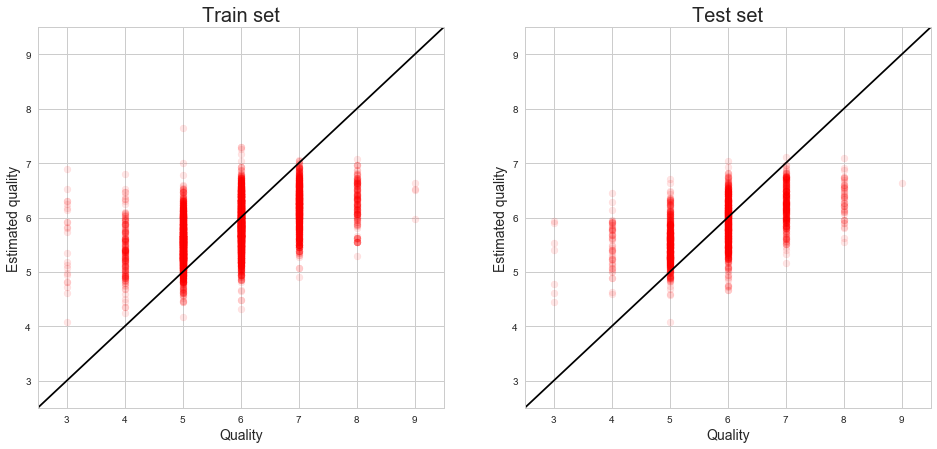

In [94]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.scatter(y_train, lm.predict(X_train), color="red", alpha=0.1)
plt.xlim(2.5,9.5)
plt.ylim(2.5,9.5)
plt.plot(range(11), color='black')

plt.title('Train set', fontsize=20)
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
plt.scatter(y_test, lm.predict(X_test), color="red", alpha=0.1)
plt.xlim(2.5,9.5)
plt.ylim(2.5,9.5)
plt.plot(range(11), color='black')

plt.title('Test set', fontsize=20)
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

Посчитаем коэффициент детерминации — долю объяснённой моделью дисперсии отклика:

In [95]:
lm.score(X_test, y_test)

0.3171353469892202

## Случайный лес

Построим на обучающей выборке случайный лес:

In [96]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)

In [97]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Качество выросло ещё сильнее, хотя модель и переобучилась:

In [98]:
sqrt(mean_squared_error(rf.predict(X_train), y_train))

0.348070845746034

In [99]:
sqrt(mean_squared_error(rf.predict(X_test), y_test))

0.6164308177724361

Истинные оценки вин и их предсказания случайным лесом:

Text(0,0.5,'Estimated quality')

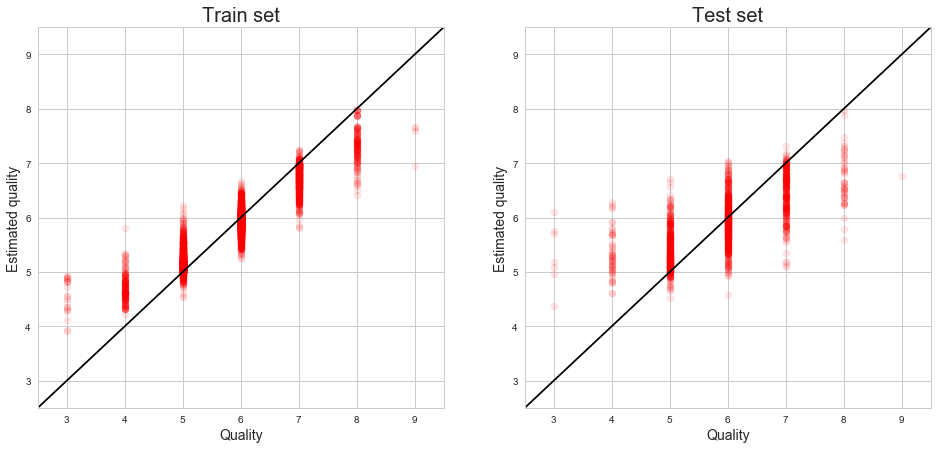

In [102]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.scatter(y_train, rf.predict(X_train), color="red", alpha=0.1)
plt.xlim(2.5,9.5)
plt.ylim(2.5,9.5)
plt.plot(range(11), color='black')
plt.title('Train set', fontsize=20)
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
plt.scatter(y_test, rf.predict(X_test), color="red", alpha=0.1)
plt.xlim(2.5,9.5)
plt.ylim(2.5,9.5)
plt.plot(range(11), color='black')
plt.title('Test set', fontsize=20)
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

Коэффициент детерминации для случайного леса:

In [103]:
rf.score(X_test, y_test)

0.5002315802333492

Сравним ошибки линейной регрессии и случайного леса на тестовой выборке:

Text(0.5,0,'Difference of absolute errors')

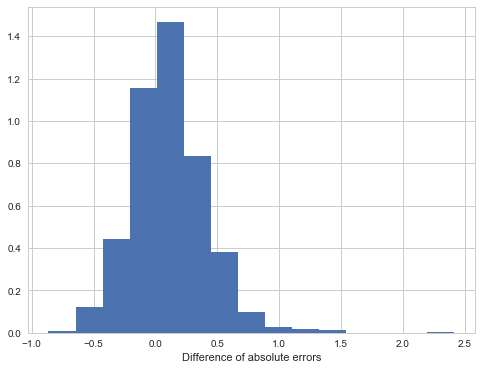

In [107]:
plt.figure(figsize=(8,6))
plt.hist(abs(y_test - lm.predict(X_test)) - abs(y_test - rf.predict(X_test)), bins=15, density=True)
plt.xlabel('Difference of absolute errors')

Различия между средними абсолютными ошибками значимы:

In [108]:
tmeans = sm.CompareMeans(sm.DescrStatsW(abs(y_test - lm.predict(X_test))), 
                         sm.DescrStatsW(abs(y_test - rf.predict(X_test))))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

8.297280279124315e-13

95% доверительный интервал для средней разности абсолютных ошибок:

In [109]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.0800009133745288, 0.14004988300252813)

То есть, используя вместо линейной регрессии наш случайный лес, мы предсказываем экспертную оценку в среднем на 0.26-0.30 баллов точнее.

Давайте посмотрим, какие признаки обладают наибольшей предсказательной способностью:

In [113]:
importances = pd.DataFrame(list(zip(X_train.columns, rf.feature_importances_)))
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature name,importance
11,Alcohol (%),0.274863
2,Volatile acidity (g/l),0.140797
6,Free sulfur dioxide (mg/l),0.086801
10,Sulphates (g/l),0.076346
7,Total sulfur dioxide (mg/l),0.065633
3,Citric acid (g/l),0.064433
9,pH,0.062901
4,Residual sugar (g/l),0.061058
5,Chlorides (g/l),0.059893
8,Density (g/cm3),0.056302


Cильнее всего на экспертную оценку качества вина влияет содержание алкоголя.